In [1]:
#hide
# Import time!
from loguru import logger
from rich.logging import RichHandler

# Logging setup
logger.configure(
    handlers=[
        {
            "sink": RichHandler(
                log_time_format="%Y-%m-%d %X",
                rich_tracebacks=True,
                show_path=False,
                tracebacks_width=200,
            ),
            "format": "{message}",
            "level": "DEBUG",
        }
    ]
)

[1]

In [2]:
from fastai.imports import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(linewidth=130)

In [3]:
from pathlib import Path
titanic_data_path = Path('./titanic/')

In [4]:
train_df = pd.read_csv(titanic_data_path / 'train.csv')
test_df = pd.read_csv(titanic_data_path / 'test.csv')

In [5]:
training_modes = train_df.mode().iloc[0]

def process_titanic_data(df):
    df['Fare'] = df.Fare.fillna(0)
    df.fillna(training_modes, inplace=True)
    df['LogFare'] = np.log1p(df['Fare'])
    df['Embarked'] = pd.Categorical(df.Embarked)
    df['Sex'] = pd.Categorical(df.Sex)

process_titanic_data(train_df)
process_titanic_data(test_df)

In [6]:
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,B96 B98,S,2.110213
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C,4.280593
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,B96 B98,S,2.188856
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,3.990834
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,B96 B98,S,2.202765
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,B96 B98,S,2.639057
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,3.433987
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,24.0,1,2,W./C. 6607,23.4500,B96 B98,S,3.196630
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,3.433987


In [7]:
categorial_vars = ['Sex', 'Embarked']
continuous_vars = ['Age', 'SibSp', 'Parch', 'LogFare', 'Pclass']
dependent_var = 'Survived'

In [8]:
train_df.Sex.head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: category
Categories (2, object): ['female', 'male']

In [9]:
train_df.Sex.cat.codes.head()

0    1
1    0
2    0
3    0
4    1
dtype: int8

# Forest -> Trees -> Binary Splits

In [10]:
import seaborn as sns

[Text(0.5, 1.0, 'Histogram')]

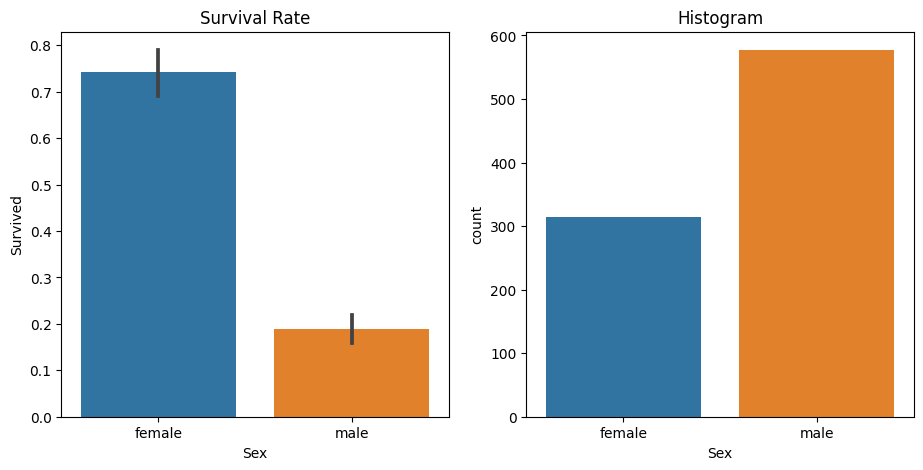

In [11]:
figure, axes = plt.subplots(1, 2, figsize=(11, 5))
sns.barplot(data=train_df, y=dependent_var, x='Sex', ax=axes[0]).set(title='Survival Rate')
sns.countplot(data=train_df, x='Sex', ax=axes[1]).set(title='Histogram')

Based on the above, honestly how bad would the result be if we just guessed based on sex if they survived or not? I mean... probably not terrible!

In [12]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
_train_df, _val_df = train_test_split(train_df, test_size=0.25)
_train_df[categorial_vars] = _train_df[categorial_vars].apply(lambda x: x.cat.codes)
_val_df[categorial_vars] = _val_df[categorial_vars].apply(lambda x: x.cat.codes)

In [13]:
def get_vars(df):
    xs = df[categorial_vars+continuous_vars].copy()
    return (xs, df[dependent_var] if dependent_var in df else None)

_train_xs, _train_y = get_vars(_train_df)
_val_xs, _val_y = get_vars(_val_df)

In [14]:
# Now, predict they survived if they were female
predictions = _val_xs.Sex == 0

In [15]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(_val_y, predictions)

0.21524663677130046

0.215 error isn't that bad at all for something so basic!

Now, let's try considering fare as well

<Axes: xlabel='LogFare', ylabel='Density'>

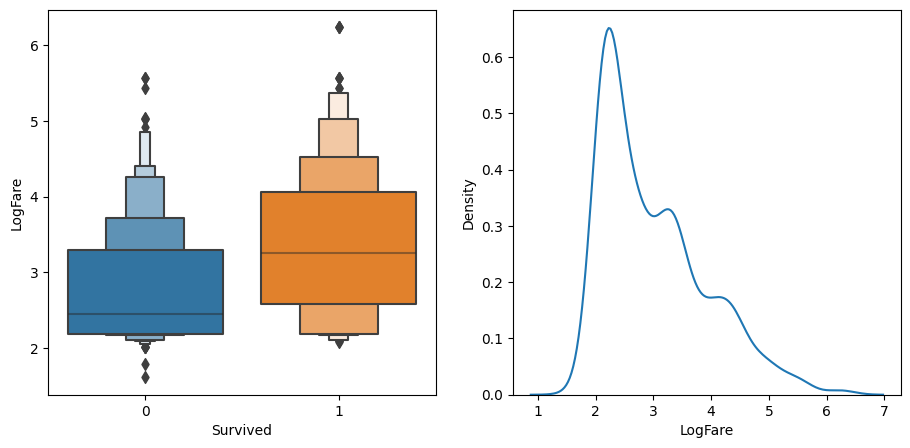

In [16]:
_train_df_fare = _train_df[_train_df.LogFare > 0]
figure, axes = plt.subplots(1, 2, figsize=(11, 5))
sns.boxenplot(data=_train_df_fare, x=dependent_var, y='LogFare', ax=axes[0])
sns.kdeplot(data=_train_df_fare, x='LogFare', ax=axes[1])

Based on the above, there's definitely a difference between those that survived and those that didn't.

So, what if we split on ~2.7? That might be a reasonable prediction for when someone might be more likely to survive.

In [17]:
predictions = _val_xs.LogFare > 2.7
mean_absolute_error(_val_y, predictions)

0.336322869955157

So, based on this, it would be good to create something a bit more interactive to see what the score is to find the best split

In [18]:
def _side_score(side, y):
    total = side.sum()
    return (
        0 if total <= 1
        else y[side].std() * total
    )

In [19]:
def score(column, y, split_on):
    lhs = column <= split_on
    return (_side_score(lhs, y) + _side_score(~lhs, y))/len(y)

In [20]:
score(_train_xs['Sex'], _train_y, 0.5)

0.40787530982063946

In [21]:
score(_train_xs['LogFare'], _train_y, 2.7)

0.47180873952099694

Now that we have this, we can create an interactive tool!

In [22]:
def iscore(nm, split_on):
    column = _train_xs[nm]
    return score(column, _train_y, split_on)

from ipywidgets import interact
interact(nm=continuous_vars, split_on=15.5)(iscore)

interactive(children=(Dropdown(description='nm', options=('Age', 'SibSp', 'Parch', 'LogFare', 'Pclass'), value…

<function __main__.iscore(nm, split_on)>

In [23]:
interact(nm=categorial_vars, split_on=0)(iscore)

interactive(children=(Dropdown(description='nm', options=('Sex', 'Embarked'), value='Sex'), IntSlider(value=0,…

<function __main__.iscore(nm, split_on)>

We can try to do the same process automatically by, e.g., just trying to do the split for all values for age

In [24]:
nm = 'Age'
age_column = _train_xs[nm]
unique_ages = age_column.unique()
unique_ages.sort()
unique_ages

array([ 0.42,  0.67,  0.75,  0.83,  0.92,  1.  ,  2.  ,  3.  ,  4.  ,  5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  , 11.  , 12.  ,
       13.  , 14.  , 14.5 , 15.  , 16.  , 17.  , 18.  , 19.  , 20.  , 21.  , 22.  , 23.  , 24.  , 24.5 , 25.  , 26.  , 27.  ,
       28.  , 28.5 , 29.  , 30.  , 31.  , 32.  , 32.5 , 33.  , 34.  , 34.5 , 35.  , 36.  , 36.5 , 37.  , 38.  , 39.  , 40.  ,
       40.5 , 41.  , 42.  , 43.  , 44.  , 45.  , 45.5 , 46.  , 47.  , 48.  , 49.  , 50.  , 51.  , 52.  , 53.  , 54.  , 55.  ,
       55.5 , 56.  , 57.  , 58.  , 59.  , 60.  , 61.  , 62.  , 64.  , 65.  , 70.  , 70.5 , 74.  , 80.  ])

In [25]:
age_scores = np.array([score(age_column, _train_y, _age) for _age in unique_ages if not np.isnan(_age)])
unique_ages[age_scores.argmin()]

6.0

In [26]:
def best_column_split(df, nm):
    column, y = df[nm], df[dependent_var]
    unique_vals = column.dropna().unique()
    scores = np.array([score(column, y, val) for val in unique_vals if not np.isnan(val)])
    min_idx = scores.argmin()
    return unique_vals[min_idx], scores[min_idx]

best_column_split(train_df, 'Age')

(6.0, 0.48098442191737467)

In [27]:
columns = [*categorial_vars, *continuous_vars]
{column: best_column_split(_train_df, column) for column in columns}

{'Sex': (0, 0.40787530982063946),
 'Embarked': (0, 0.47883342573147836),
 'Age': (6.0, 0.478316717508991),
 'SibSp': (4, 0.4783740258817434),
 'Parch': (0, 0.4805296527841601),
 'LogFare': (2.4390808375825834, 0.4620823937736597),
 'Pclass': (2, 0.46048261885806596)}

This is basically the OneR rule where we use the best single rule to separate our data into 2 groups whose values differ as little as possible intra-group, but as much as possible inter-group.

Great baseline!

Now, we should consider "TwoR": basically do the same thing again within each group, ie. find the best single rule which splits males (and again for females), and use those to create 2 groups.

Time to find out what the best split here would be!

In [28]:
columns.remove('Sex')
is_male = _train_df.Sex == 1
males, females = _train_df[is_male], _train_df[~is_male]

Let's find out the best binary split for males...

In [29]:
{val: best_column_split(males, val) for val in columns}

{'Embarked': (0, 0.3875581870410906),
 'Age': (6.0, 0.3739828371010595),
 'SibSp': (4, 0.3875864227586273),
 'Parch': (0, 0.3874704821461959),
 'LogFare': (2.803360380906535, 0.3804856231758151),
 'Pclass': (1, 0.38155442004360934)}

And for females...

In [30]:
{val: best_column_split(females, val) for val in columns}

{'Embarked': (0, 0.4295252982857327),
 'Age': (50.0, 0.4225927658431649),
 'SibSp': (4, 0.42319212059713535),
 'Parch': (3, 0.4193314500446158),
 'LogFare': (4.256321678298823, 0.41350598332911376),
 'Pclass': (2, 0.3335388911567601)}

So, for males, the best predictor is `Age <= 6`, and for females, `Pclass <= 2`.

This means we now have a decision tree!

Let's lean on `sklearn` to automate creating a `DecisionTreeClassifier`...

In [31]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz

m = DecisionTreeClassifier(max_leaf_nodes=4).fit(_train_xs, _train_y)

Let's draw the outputted tree...

In [32]:
import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s = export_graphviz(
        t,
        out_file=None,
        feature_names=df.columns,
        filled=True,
        rounded=True,
        special_characters=True,
        rotate=False,
        precision=precision,
        **kwargs
    )

    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

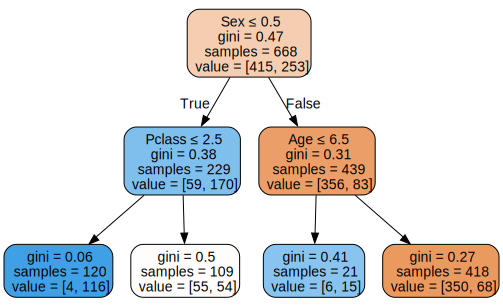

In [33]:
draw_tree(m, _train_xs, size=10)

In [34]:
# Let's add some basic code to work out the Gini coefficient
# Roughly: how likely is it that if you did 2 samples, you'd get the same value?
def gini(cond):
    act = train_df.loc[cond, dependent_var]
    return 1 - act.mean()**2 - (1 - act).mean()**2

In [35]:
(gini(train_df.Sex == 'female'), gini(train_df.Sex == 'male'))

(0.3828350034484158, 0.3064437162277842)

In [36]:
# How does the tree compare to our first OneR?
mean_absolute_error(_val_y, m.predict(_val_xs))

0.2242152466367713

That's actually slightly worse!
Let's try a bigger tree...

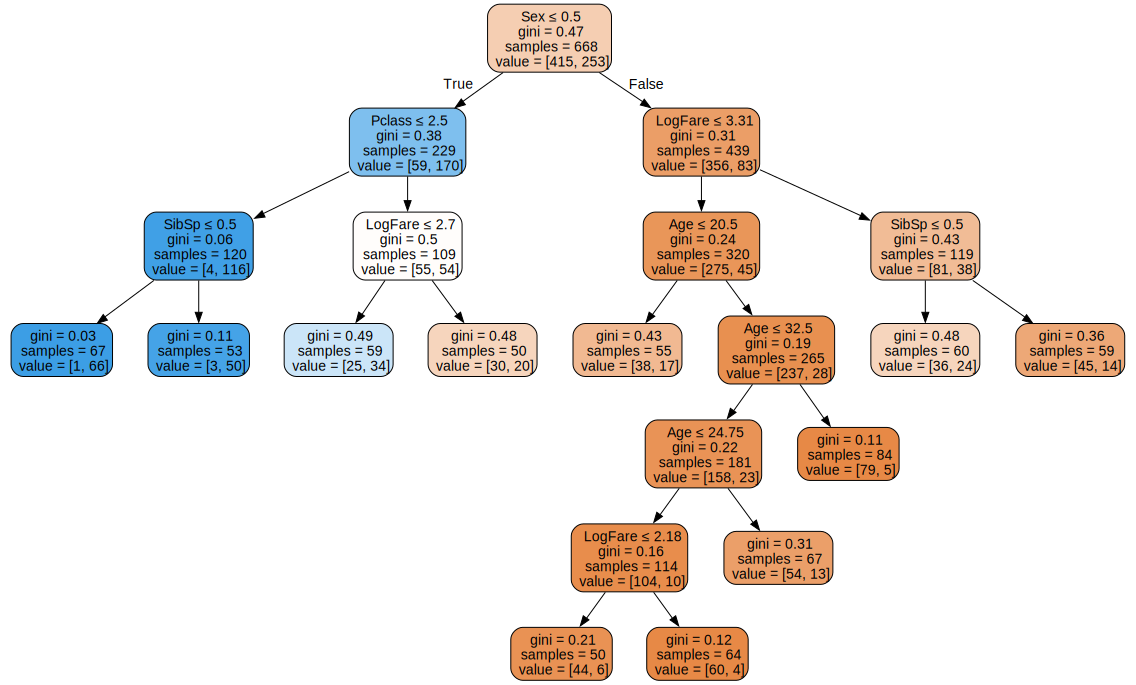

In [37]:
m = DecisionTreeClassifier(min_samples_leaf=50)
m.fit(_train_xs, _train_y)
draw_tree(m, _train_xs, size=25)

In [38]:
mean_absolute_error(_val_y, m.predict(_val_xs))

0.18385650224215247

We don't have loads of data, so breaking down the tree into more fine-grained choices will only help so much.

Instead, we'll create many trees (each with a random sample of the data), and then take the average.
This is basically a random forest!

In [39]:
def get_tree(proportion=0.75):
    row_count = len(_train_y)
    row_indices = np.random.choice(row_count, int(row_count*proportion))
    return DecisionTreeClassifier(min_samples_leaf=5).fit(_train_xs.iloc[row_indices], _train_y.iloc[row_indices])

In [40]:
trees = [get_tree() for _ in range(100)]

In [41]:
all_probs = [tree.predict(_val_xs) for tree in trees]
avg_probs = np.stack(all_probs).mean(0)

mean_absolute_error(_val_y, avg_probs)

0.2272645739910314

Random forests do one extra thing, which is that they take a subset of the columns as well, to help with randomness.

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(100, min_samples_leaf=5)
rf.fit(_train_xs, _train_y)
mean_absolute_error(_val_y, rf.predict(_val_xs))

0.18834080717488788

Using random forests, you can create something called a "feature importance plot" which is a summary of how much each column decreased the Gini coefficient by. Really useful to find out what the most dominant effects are!

<Axes: ylabel='cols'>

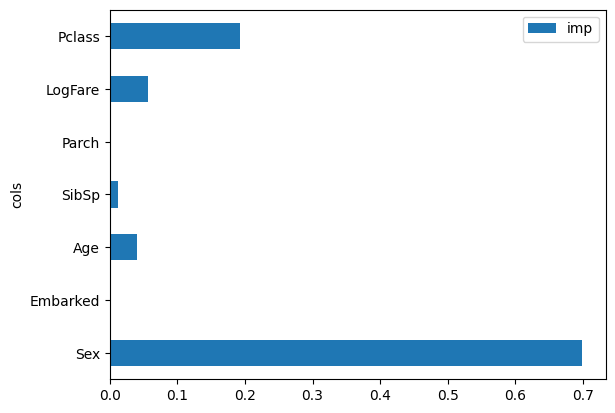

In [43]:
pd.DataFrame({'cols': _train_xs.columns, 'imp': m.feature_importances_}).plot('cols', 'imp', 'barh')

There's also Out-Of-Bag error: the error the each tree gives on the data it wasn't trained on. For small datasets, you can get away with not having a validation set using this

We can also think about the standard deviation of the outputs to give confidence to our predictions:

In [44]:
predictions = np.stack([tree.predict(_val_xs) for tree in rf.estimators_])
predictions.shape

/Users/kmccarro/miniconda3/envs/fast_ai/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/kmccarro/miniconda3/envs/fast_ai/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/kmccarro/miniconda3/envs/fast_ai/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/kmccarro/miniconda3/envs/fast_ai/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Users/kmccarro/miniconda3/envs/fast_ai/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.w

(100, 223)

In [45]:
predictions_std = predictions.std(0)
predictions_std[:5]

array([0.43863424, 0.21794495, 0.3       , 0.2712932 , 0.49959984])

To consider how the dependent variable is affected by a particular column, you can consider using a partial dependence plot:

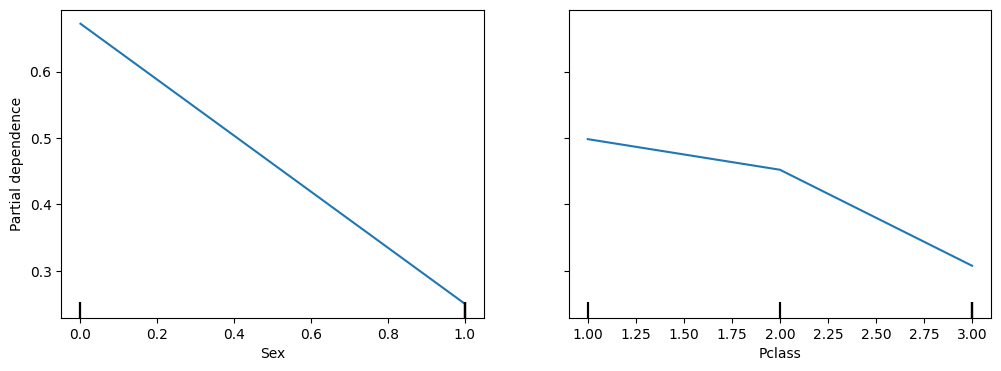

In [46]:
from sklearn.inspection import PartialDependenceDisplay

figure, axes = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(rf, _val_xs, ['Sex', 'Pclass'], grid_resolution=20, ax=axes)